In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from datetime import datetime
import glob
import random
import os
from pathlib import Path
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from pycaret.classification import *
import xgboost
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMClassifier
from sklearn.svm import SVR
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, RobustScaler, Normalizer, MinMaxScaler

CATEGORIES = {'high': 1, 'midhigh': 2, 'mid': 3, 'midlow': 4, 'low': 5}
COLORS = ['#476A2A', '#7851B8', '#BD3430', '#4A2D4E', '#875525']

def image_loader_new(folder): 
    base = Path('{}'.format(folder)).glob('**/*')
    all_files = [str(x) for x in base if x.is_file()]
    targets = [x.split('\\')[1] for x in all_files]
    steel_grade = [x.split('\\')[2] for x in all_files]
    dataset = pd.DataFrame({'path': all_files, 'target': targets, 'steel_grade': steel_grade})
    return dataset

def image_preprocess_gray(image, clipLimit=2.27, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=tileGridSize) # clipLimit=0.5, tileGridSize=(8,32)
    image                   = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image                   = image[403:630, :].astype(np.uint8).copy()
    image                   = clahe.apply(image)
    gray                    = image[:, 266:1776].astype(np.uint8).copy()

    return gray

def image_preprocess_value_Small_Rolling(image, clipLimit=1.05, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=tileGridSize) # clipLimit=0.5, tileGridSize=(8,32)
    image                   = cv2.imread(image, cv2.IMREAD_COLOR)
    image                   = image[403:630, 266:1776].astype(np.uint8).copy()
# 1단계: 배경제거코드 적용 : 색상검출방식으로 블룸검출사진 및 스케일검출사진 분리
    image_ycrcb                 = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # YCrCb색상으로 변경
# 2단계: 히스토그램 평활화 적용 : contrast 상향
# 2-1) 블룸검출사진 히스토그램 평활화
    planes_cla_bloom        = cv2.split(image_ycrcb)
    planes_cla_bloom[0]     = clahe.apply(planes_cla_bloom[0]) # Y:밝기 히스토그램 평활화 : 컬러이미지
    bloom_ycrcb_aeq         = cv2.merge(planes_cla_bloom)
    bloom_bgr_aeq           = cv2.cvtColor(bloom_ycrcb_aeq, cv2.COLOR_YCrCb2BGR) #  컬러이미지 BGR로 변경
    bloom_hsv_aeq           = cv2.cvtColor(bloom_bgr_aeq, cv2.COLOR_BGR2HSV) #  컬러이미지 HSV로 변경하여 완성!
    planes_aeq_bloom        = cv2.split(bloom_hsv_aeq)

    value                   = planes_aeq_bloom[2] # Value채도
    return value


def image_preprocess_value_Small_Rolling_channel(image, clipLimit=1.05, tileGridSize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize=tileGridSize) # clipLimit=0.5, tileGridSize=(8,32)
    image                   = cv2.imread(image, cv2.IMREAD_COLOR)
    image                   = image[403:630, 266:1776].astype(np.uint8).copy()
# 1단계: 배경제거코드 적용 : 색상검출방식으로 블룸검출사진 및 스케일검출사진 분리
    image_ycrcb                 = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # YCrCb색상으로 변경
# 2단계: 히스토그램 평활화 적용 : contrast 상향
# 2-1) 블룸검출사진 히스토그램 평활화
    planes_cla_bloom        = cv2.split(image_ycrcb)
    #planes_cla_bloom[0]     = clahe.apply(planes_cla_bloom[0]) # Y:밝기 히스토그램 평활화 : 컬러이미지
    planes_cla_bloom_0     = clahe.apply(planes_cla_bloom[0]) # Y:밝기 히스토그램 평활화 : 컬러이미지       
    bloom_ycrcb_aeq         = cv2.merge(planes_cla_bloom)
    bloom_bgr_aeq           = cv2.cvtColor(bloom_ycrcb_aeq, cv2.COLOR_YCrCb2BGR) #  컬러이미지 BGR로 변경
    bloom_bgr_aeq_split     = cv2.split(bloom_bgr_aeq)
    bloom_hsv_aeq           = cv2.cvtColor(bloom_bgr_aeq, cv2.COLOR_BGR2HSV) #  컬러이미지 HSV로 변경하여 완성!
    planes_aeq_bloom        = cv2.split(bloom_hsv_aeq)

    value                   = planes_aeq_bloom[2] # Value 명도
    gray                    = planes_cla_bloom_0 # gray 명암
    red                     = bloom_bgr_aeq_split[2] # red 빨강
    green                   = bloom_bgr_aeq_split[1] # green 녹색
    blue                    = bloom_bgr_aeq_split[0] # blue 파랑
    saturation              = planes_aeq_bloom[1] # saturation 채도
    hue                     = planes_aeq_bloom[0] # hue 색조
    Cr                      = planes_cla_bloom[1] # Cr
    Cb                      = planes_cla_bloom[2] # Cb
    edge                   = cv2.Canny(gray, 190, 220) # 엣지검출
    
    return value, gray, red, green, blue, saturation, hue, Cr, Cb, edge





# 다양한 오차 측정 지표를 확인하기 위한 함수 정의

from sklearn.metrics import *

def get_loss(y_test, y_predict, i): 
    # explained_variance_score =  explained_variance_score(y_test, pred)
    MSE = mean_squared_error(y_test, y_predict)
    RMSE = np.sqrt(MSE)
    r2 = r2_score(y_test, y_predict)
    print('model: {}, MSE: {:.4f}, RMSE: {:.4f}, r2: {:.4f}'.format(Model_name[i], MSE, RMSE, r2))
    
# y_predict = xgb_model.predict(x_test)
# # get_clf_eval()를 이용해 사키릿런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가
# get_loss(y_test, y_predict)

# 사이킷런의 정확도, 정밀도, 재현율, 오차행렬을 계산하는 API 호출
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 호출한 지표들을 한꺼번에 계산하는 함수 정의
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

In [2]:
def data_preprocess(folder, clipLimit, tileGridSize):
    images = image_loader_new(folder)
    # print(images.shape)

    paths = images.path.values # path라는 컬럼의 값을 np.array로 만든다. images['path'].values와 같다.

    hists = []
    for idx, image in enumerate(paths):
        image = image_preprocess_gray(image, clipLimit, tileGridSize)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        hists.append(hist)

    targets = [CATEGORIES[target] for target in images.target.values] # high=1, midhigh=2, mid=3, midlow=4, low=5로 대치한다 

    dataset = pd.DataFrame.from_records(hists) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset = pd.concat([dataset, pd.DataFrame(targets, columns=['target'])], axis=1) # target도 y변수로 취합한다.
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=111) # stratify : 1,2,3,4,5등급을 균등하게 나누어주는 인수

    return dataset, train_dataset, test_dataset

def data_preprocess_Small_Rolling(folder, clipLimit, tileGridSize):
    images = image_loader_new(folder)
    print(images.shape)

    paths = images.path.values # path라는 컬럼의 값을 np.array로 만든다. images['path'].values와 같다.

    hists_1 = []
    hists_2 = []
    hists_3 = []
    hists_4 = []
    hists_5 = []
    hists_6 = []
    hists_7 = []
    hists_8 = []
    hists_9 = []
    hists_10= []


    for idx, image in enumerate(paths):
        print(image)
        # image = image_preprocess_value_Small_Rolling(image, clipLimit, tileGridSize)
        value, gray, red, green, blue, saturation, hue, Cr, Cb, edge  = image_preprocess_value_Small_Rolling_channel(image, clipLimit, tileGridSize)

        value = cv2.calcHist([value], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        gray = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        red = cv2.calcHist([red], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        green = cv2.calcHist([green], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        blue = cv2.calcHist([blue], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        saturation = cv2.calcHist([saturation], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        hue = cv2.calcHist([hue], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        Cr = cv2.calcHist([Cr], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        Cb = cv2.calcHist([Cb], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트
        Edge = cv2.calcHist([edge], [0], None, [256], [0, 256]).flatten() # histogram이라는 list를 hists에 넣는다. 2차원 리스트

        hists_1.append(value)
        hists_2.append(gray)
        hists_3.append(red)
        hists_4.append(green)
        hists_5.append(blue)
        hists_6.append(saturation)
        hists_7.append(hue)
        hists_8.append(Cr)
        hists_9.append(Cb)
        hists_10.append(Edge)



    targets = [CATEGORIES[target] for target in images.target.values] # high=1, midhigh=2, mid=3, midlow=4, low=5로 대치한다 

    # dataset = pd.DataFrame.from_records(hists) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_value = pd.DataFrame.from_records(hists_1) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_value.columns = list('value_{}'.format(n) for n in range(256))
    dataset_gray = pd.DataFrame.from_records(hists_2) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_gray.columns = list('gray_{}'.format(n) for n in range(256))
    dataset_red = pd.DataFrame.from_records(hists_3) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_red.columns = list('red_{}'.format(n) for n in range(256))
    dataset_green = pd.DataFrame.from_records(hists_4) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_green.columns = list('green_{}'.format(n) for n in range(256))
    dataset_blue = pd.DataFrame.from_records(hists_5) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_blue.columns = list('blue_{}'.format(n) for n in range(256))
    # dataset_blue = dataset_blue[['blue_19', 'blue_20', 'blue_21', 'blue_22', 'blue_23', 'blue_24']]
    dataset_saturation = pd.DataFrame.from_records(hists_6) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_saturation.columns = list('saturation_{}'.format(n) for n in range(256))
    dataset_hue = pd.DataFrame.from_records(hists_7) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_hue.columns = list('hue_{}'.format(n) for n in range(256))
    dataset_Cr = pd.DataFrame.from_records(hists_8) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_Cr.columns = list('Cr_{}'.format(n) for n in range(256))
    dataset_Cb = pd.DataFrame.from_records(hists_9) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_Cb.columns = list('Cb_{}'.format(n) for n in range(256))
    dataset_Edge = pd.DataFrame.from_records(hists_10) # from_records: list를 dataframe으로 만든다. 0 ~ 255는 x변수로 나타남
    dataset_Edge.columns = list('edge_{}'.format(n) for n in range(256))
    dataset_Edge = dataset_Edge[['edge_255']]
    dataset_Edge['edge_255'] = dataset_Edge['edge_255']



    # dataset = pd.concat([dataset, pd.DataFrame(targets, columns=['target'])], axis=1) # target도 y변수로 취합한다.
    dataset = pd.concat([dataset_gray, dataset_blue, dataset_Edge, pd.DataFrame(targets, columns=['target'])], axis=1) # target도 y변수로 취합한다.
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, stratify=dataset['target'], random_state=111) # stratify : 1,2,3,4,5등급을 균등하게 나누어주는 인수

    return dataset, train_dataset, test_dataset

def data_split(dataset):
    X = dataset.drop('target', axis=1)
    Y = dataset['target']

    return X, Y

def XG_preprocessing(y_train, y_test):
    # xgb boost 전처리
    y_train_xgb = [v-1 for v in y_train]
    y_val_xgb = [v-1 for v in y_test]

    return y_train_xgb, y_val_xgb

def robustScaler(train_dataset, validation_dataset):
    # 변형 객체 생성
    robust_scaler = RobustScaler()
    X_train_dataset = train_dataset.drop('target', axis=1)
    #컬럼받기
    Col_Lst = list(X_train_dataset.columns) 
    # Col_Lst들에 전부 스케일러 적용한후 새로운 데이터프레임에 받아줌
    # 새 데이터프레임에도 Col_Lst지정해주어야!!
    train_dataset_scaler = train_dataset.copy()
    validation_dataset_scaler = validation_dataset.copy()

    # 훈련데이터의 모수 분포 저장 및 스케일링
    train_dataset_scaler[Col_Lst] = robust_scaler.fit_transform(train_dataset[Col_Lst]) 
    # 테스트 데이터의 모수 분포 저장 및 스케일링
    validation_dataset_scaler[Col_Lst] = robust_scaler.transform(validation_dataset[Col_Lst])

    return train_dataset_scaler, validation_dataset_scaler


def normalScaler(train_dataset, validation_dataset):
    # 변형 객체 생성
    normal_scaler = Normalizer()
    X_train_dataset = train_dataset.drop('target', axis=1)
    #컬럼받기
    Col_Lst = list(X_train_dataset.columns) 
    # Col_Lst들에 전부 스케일러 적용한후 새로운 데이터프레임에 받아줌
    # 새 데이터프레임에도 Col_Lst지정해주어야!!
    train_dataset_scaler = train_dataset.copy()
    validation_dataset_scaler = validation_dataset.copy()

    # 훈련데이터의 모수 분포 저장 및 스케일링
    train_dataset_scaler[Col_Lst] = normal_scaler.fit_transform(train_dataset[Col_Lst]) 
    # 테스트 데이터의 모수 분포 저장 및 스케일링
    validation_dataset_scaler[Col_Lst] = normal_scaler.transform(validation_dataset[Col_Lst])

    return train_dataset_scaler, validation_dataset_scaler

def minmaxScaler(train_dataset, validation_dataset):
    # 변형 객체 생성
    minmax_scaler = MinMaxScaler()
    X_train_dataset = train_dataset.drop('target', axis=1)
    #컬럼받기
    Col_Lst = list(X_train_dataset.columns) 
    # Col_Lst들에 전부 스케일러 적용한후 새로운 데이터프레임에 받아줌
    # 새 데이터프레임에도 Col_Lst지정해주어야!!
    train_dataset_scaler = train_dataset.copy()
    validation_dataset_scaler = validation_dataset.copy()

    # 훈련데이터의 모수 분포 저장 및 스케일링
    train_dataset_scaler[Col_Lst] = minmax_scaler.fit_transform(train_dataset[Col_Lst]) 
    # 테스트 데이터의 모수 분포 저장 및 스케일링
    validation_dataset_scaler[Col_Lst] = minmax_scaler.transform(validation_dataset[Col_Lst])

    return train_dataset_scaler, validation_dataset_scaler


def select_feature(dataset):
    Col_Lst = [92, 69, 71, 79, 90, 67, 98, 174, 'target']
    dataset([Col_Lst])
    return dataset

In [182]:
clipLimit = 0.5 # 3차 개발
tileGridSize = (8,8)
folder = 'Train_data'
dataset, train_dataset, validation_dataset = data_preprocess_Small_Rolling(folder, clipLimit, tileGridSize)
x_train, y_train = data_split(train_dataset)
x_val, y_val = data_split(validation_dataset)
y_train_xgb, y_val_xgb = XG_preprocessing(y_train, y_val)
train_dataset_scaler, validation_dataset_scaler = minmaxScaler(train_dataset, validation_dataset)
dataset_scaler, validation_dataset_scaler = minmaxScaler(dataset, validation_dataset)
X, Y = data_split(dataset)
N, Y_xgb = XG_preprocessing(Y, Y)

# feature  선택한 dataframe
dataset_select = dataset[['gray_92', 'gray_69', 'gray_71', 'gray_79', 'gray_90', 'gray_67', 'gray_98', 'gray_174', 'target']]
X_select, Y_select = data_split(dataset_select)


print(
    'train_dataset: ', pd.DataFrame(train_dataset).shape,
    'validation_dataset: ', pd.DataFrame(validation_dataset).shape,
    'x_train: ', pd.DataFrame(x_train).shape,
    'y_train: ', pd.DataFrame(y_train).shape,
    'x_val: ', pd.DataFrame(x_val).shape,
    'y_val: ', pd.DataFrame(y_val).shape,
    'y_train_xgb: ', pd.DataFrame(y_train_xgb).shape,
    'y_val_xgb: ', pd.DataFrame(y_val_xgb).shape,
    'train_dataset_scaler: ', pd.DataFrame(train_dataset_scaler).shape,
    'validation_dataset_scaler: ', pd.DataFrame(validation_dataset_scaler).shape,
      )

folder = 'Valid_data'
dataset_val, train_dataset_val, validation_dataset_val = data_preprocess_Small_Rolling(folder, clipLimit, tileGridSize)
x_test, y_test = data_split(dataset_val)
y_test_xgb, y_test_xgb = XG_preprocessing(y_test, y_test)
N, testset_scaler = minmaxScaler(dataset_val, dataset_val)
x_test_scaled, y_test = data_split(testset_scaler)

# feature  선택한 dataframe
testset_scaler_select = dataset_val[['gray_92', 'gray_69', 'gray_71', 'gray_79', 'gray_90', 'gray_67', 'gray_98', 'gray_174', 'target']]
X_test_select, Y_test_select = data_split(testset_scaler_select)


print(
    'x_test: ', pd.DataFrame(x_test).shape,
    'y_test: ', pd.DataFrame(y_test).shape,
    'y_test_xgb: ', pd.DataFrame(y_test_xgb).shape,
    'testset_scaler: ', pd.DataFrame(testset_scaler).shape,
    'x_test_scaled: ', pd.DataFrame(x_test_scaled).shape,
    'data X변수', dataset.columns, len(dataset.columns)   
      )

(1790, 3)
Train_data\high\20220416060009_D22S4K1382-014_1.jpg
Train_data\high\20220416060020_D22S4K1382-014_2.jpg
Train_data\high\20220416060028_D22S4K1382-014_3.jpg
Train_data\high\20220416060119_D22S4K1382-015_2.jpg
Train_data\high\20220416060127_D22S4K1382-015_3.jpg
Train_data\high\20220416060240_D22S4K1383-001_1.jpg
Train_data\high\20220416060258_D22S4K1383-001_3.jpg
Train_data\high\20220416060339_D22S4K1383-002_1.jpg
Train_data\high\20220416060350_D22S4K1383-002_2.jpg
Train_data\high\20220416060358_D22S4K1383-002_3.jpg
Train_data\high\20220416060449_D22S4K1383-003_2.jpg
Train_data\high\20220416060457_D22S4K1383-003_3.jpg
Train_data\high\20220416060549_D22S4K1383-004_2.jpg
Train_data\high\20220416060557_D22S4K1383-004_3.jpg
Train_data\high\20220416060707_D22S4K1383-005_1.jpg
Train_data\high\20220416060718_D22S4K1383-005_2.jpg
Train_data\high\20220416060726_D22S4K1383-005_3.jpg
Train_data\high\20220416060817_D22S4K1383-006_2.jpg
Train_data\high\20220416060934_D22S4K1369-001_1.jpg
Tr

In [111]:
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 800)
dataset_scaler.describe()

,gray_0,gray_1,gray_2,gray_3,gray_4,gray_5,gray_6,gray_7,gray_8,gray_9,gray_10,gray_11,gray_12,gray_13,gray_14,gray_15,gray_16,gray_17,gray_18,gray_19,gray_20,gray_21,gray_22,gray_23,gray_24,gray_25,gray_26,gray_27,gray_28,gray_29,gray_30,gray_31,gray_32,gray_33,gray_34,gray_35,gray_36,gray_37,gray_38,gray_39,gray_40,gray_41,gray_42,gray_43,gray_44,gray_45,gray_46,gray_47,gray_48,gray_49,gray_50,gray_51,gray_52,gray_53,gray_54,gray_55,gray_56,gray_57,gray_58,gray_59,gray_60,gray_61,gray_62,gray_63,gray_64,gray_65,gray_66,gray_67,gray_68,gray_69,gray_70,gray_71,gray_72,gray_73,gray_74,gray_75,gray_76,gray_77,gray_78,gray_79,gray_80,gray_81,gray_82,gray_83,gray_84,gray_85,gray_86,gray_87,gray_88,gray_89,gray_90,gray_91,gray_92,gray_93,gray_94,gray_95,gray_96,gray_97,gray_98,gray_99,gray_100,gray_101,gray_102,gray_103,gray_104,gray_105,gray_106,gray_107,gray_108,gray_109,gray_110,gray_111,gray_112,gray_113,gray_114,gray_115,gray_116,gray_117,gray_118,gray_119,gray_120,gray_121,gray_122,gray_123,gray_124,gray_125,gray_126,gray_127,gray_128,gray_129,gray_130,gray_131,gray_132,gray_133,gray_134,gray_135,gray_136,gray_137,gray_138,gray_139,gray_140,gray_141,gray_142,gray_143,gray_144,gray_145,gray_146,gray_147,gray_148,gray_149,gray_150,gray_151,gray_152,gray_153,gray_154,gray_155,gray_156,gray_157,gray_158,gray_159,gray_160,gray_161,gray_162,gray_163,gray_164,gray_165,gray_166,gray_167,gray_168,gray_169,gray_170,gray_171,gray_172,gray_173,gray_174,gray_175,gray_176,gray_177,gray_178,gray_179,gray_180,gray_181,gray_182,gray_183,gray_184,gray_185,gray_186,gray_187,gray_188,gray_189,gray_190,gray_191,gray_192,gray_193,gray_194,gray_195,gray_196,gray_197,gray_198,gray_199,gray_200,gray_201,gray_202,gray_203,gray_204,gray_205,gray_206,gray_207,gray_208,gray_209,gray_210,gray_211,gray_212,gray_213,gray_214,gray_215,gray_216,gray_217,gray_218,gray_219,gray_220,gray_221,gray_222,gray_223,gray_224,gray_225,gray_226,gray_227,gray_228,gray_229,gray_230,gray_231,gray_232,gray_233,gray_234,gray_235,gray_236,gray_237,gray_238,gray_239,gray_240,gray_241,gray_242,gray_243,gray_244,gray_245,gray_246,gray_247,gray_248,gray_249,gray_250,gray_251,gray_252,gray_253,gray_254,gray_255,blue_0,blue_1,blue_2,blue_3,blue_4,blue_5,blue_6,blue_7,blue_8,blue_9,blue_10,blue_11,blue_12,blue_13,blue_14,blue_15,blue_16,blue_17,blue_18,blue_19,blue_20,blue_21,blue_22,blue_23,blue_24,blue_25,blue_26,blue_27,blue_28,blue_29,blue_30,blue_31,blue_32,blue_33,blue_34,blue_35,blue_36,blue_37,blue_38,blue_39,blue_40,blue_41,blue_42,blue_43,blue_44,blue_45,blue_46,blue_47,blue_48,blue_49,blue_50,blue_51,blue_52,blue_53,blue_54,blue_55,blue_56,blue_57,blue_58,blue_59,blue_60,blue_61,blue_62,blue_63,blue_64,blue_65,blue_66,blue_67,blue_68,blue_69,blue_70,blue_71,blue_72,blue_73,blue_74,blue_75,blue_76,blue_77,blue_78,blue_79,blue_80,blue_81,blue_82,blue_83,blue_84,blue_85,blue_86,blue_87,blue_88,blue_89,blue_90,blue_91,blue_92,blue_93,blue_94,blue_95,blue_96,blue_97,blue_98,blue_99,blue_100,blue_101,blue_102,blue_103,blue_104,blue_105,blue_106,blue_107,blue_108,blue_109,blue_110,blue_111,blue_112,blue_113,blue_114,blue_115,blue_116,blue_117,blue_118,blue_119,blue_120,blue_121,blue_122,blue_123,blue_124,blue_125,blue_126,blue_127,blue_128,blue_129,blue_130,blue_131,blue_132,blue_133,blue_134,blue_135,blue_136,blue_137,blue_138,blue_139,blue_140,blue_141,blue_142,blue_143,blue_144,blue_145,blue_146,blue_147,blue_148,blue_149,blue_150,blue_151,blue_152,blue_153,blue_154,blue_155,blue_156,blue_157,blue_158,blue_159,blue_160,blue_161,blue_162,blue_163,blue_164,blue_165,blue_166,blue_167,blue_168,blue_169,blue_170,blue_171,blue_172,blue_173,blue_174,blue_175,blue_176,blue_177,blue_178,blue_179,blue_180,blue_181,blue_182,blue_183,blue_184,blue_185,blue_186,blue_187,blue_188,blue_189,blue_190,blue_191,blue_192,blue_193,blue_194,blue_195,blue_196,blue_197,blue_198,blue_199,blue_200,blue_201,blue_202,blue_203,blue_204,blue_205,blue_206,blue_207,blue_208,blue_209,blue_210,blue_211,blue_21

In [184]:
# # 선형회귀
# mlr_model = LinearRegression()

# mlr_model.fit(x_train, y_train)
# model0 = mlr_model.predict(x_test)
# xgb boost(Exstream Gradient Boosting Machine)
xgb_model = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=6031, reg_alpha=0)
xgb_model.fit(X, Y_xgb) # _get_numeric_data()
model0 = xgb_model.predict(x_test)
# randomforest
rf_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6031, verbose=0,
                       warm_start=False)
rf_model.fit(X,Y)
model1 = rf_model.predict(x_test)
# light GMB(Gradient Boosting Machine) 
LGBM_model = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6031, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
LGBM_model.fit(X,Y)
model2 = LGBM_model.predict(x_test)
# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.00018, class_weight=None,
                     criterion='gini', max_depth=22, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.000005, n_estimators=87, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
xtree_model.fit(X,Y)
model3 = xtree_model.predict(x_test)

# ExtraTreesClassifier_feature_selection
xtree_model_select = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.00018, class_weight=None,
                     criterion='gini', max_depth=22, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.000005, n_estimators=87, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
xtree_model_select.fit(X_select,Y_select)
model4 = xtree_model_select.predict(X_test_select)

print(len(x_train), len(testset_scaler))

1432 445


In [185]:
Model_call = {'model0' : model0, 'model1' : model1, 'model2':model2, 'model3':model3, 'model4':model4}
Model_name = {0 : 'xgb boost', 1 : 'randomforest', 2:'light GBM', 3:'ExtraTrees', 4:'ExtraTrees_selcted'}
pred_class = np.array([v+1 for v in model1])





# for i in np.arange(5):
    # a = 'model{}'.format(i)
print('xgb boost: ', Model_name[0])
get_clf_eval(y_test_xgb, model0)
print('randomforest: ', Model_name[1])
get_clf_eval(y_test, model1)
print('light GBM: ', Model_name[2])
get_clf_eval(y_test, model2)
print('ExtraTrees: ', Model_name[3])
get_clf_eval(y_test, model3)
print('ExtraTrees_selcted: ', Model_name[4])
get_clf_eval(Y_test_select, model4)

xgb boost:  xgb boost
오차행렬
[[83  4  1  1  0]
 [ 2 62 20  3  2]
 [ 0 11 57 20  1]
 [ 2  1 17 58 11]
 [ 4  0  3 19 63]]
정확도 : 0.7258
정밀도 : 0.7258
재현율 : 0.7258
randomforest:  randomforest
오차행렬
[[83  5  0  0  1]
 [ 2 63 14  5  5]
 [ 0 16 54 18  1]
 [ 2  1 16 60 10]
 [ 4  1  4 14 66]]
정확도 : 0.7326
정밀도 : 0.7326
재현율 : 0.7326
light GBM:  light GBM
오차행렬
[[83  5  0  1  0]
 [ 2 64 19  2  2]
 [ 0 14 55 19  1]
 [ 0  3 18 56 12]
 [ 2  0  2 18 67]]
정확도 : 0.7303
정밀도 : 0.7303
재현율 : 0.7303
ExtraTrees:  ExtraTrees
오차행렬
[[83  5  0  0  1]
 [ 4 62 12  6  5]
 [ 0 14 60 13  2]
 [ 2  1 14 64  8]
 [ 4  0  3 13 69]]
정확도 : 0.7596
정밀도 : 0.7596
재현율 : 0.7596
ExtraTrees_selcted:  ExtraTrees_selcted
오차행렬
[[65 10  5  1  8]
 [ 9 44 13 12 11]
 [ 2 18 40 23  6]
 [ 2  8 21 40 18]
 [ 5  8  6 24 46]]
정확도 : 0.5281
정밀도 : 0.5281
재현율 : 0.5281


In [200]:
numeric_features = list(dataset.drop(columns=["target"]).columns)
numeric_features
auto = setup(data=dataset, target="target",
            train_size = 0.8,
            data_split_stratify = True,
            numeric_features = numeric_features,
            session_id = 3702,
            log_experiment=True, experiment_name = "Turbo")
get_config('prep_pipe').named_steps["dtypes"].replacement

,Description,Value
0,session_id,3702
1,Target,target
2,Target Type,Multiclass
3,Label Encoded,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4"
4,Original Data,"(1790, 514)"
5,Missing Values,False
6,Numeric Features,513
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [205]:
best_3 = compare_models(n_select=3, turbo=False, fold = 10)
print(best_3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7416,0.9247,0.7417,0.7442,0.7387,0.6770,0.6789,0.3580
lightgbm,Light Gradient Boosting Machine,0.7339,0.9248,0.7340,0.7345,0.7305,0.6674,0.6692,4.5260
xgboost,Extreme Gradient Boosting,0.7269,0.9214,0.7271,0.7256,0.7231,0.6586,0.6602,7.0540
rf,Random Forest Classifier,0.7249,0.9213,0.7250,0.7256,0.7222,0.6561,0.6574,0.5230
gbc,Gradient Boosting Classifier,0.6948,0.9141,0.6949,0.6982,0.6928,0.6185,0.6203,11.6370
knn,K Neighbors Classifier,0.6766,0.8889,0.6768,0.6792,0.6737,0.5958,0.5977,0.0890
mlp,MLP Classifier,0.6326,0.7941,0.6324,0.6408,0.6253,0.5407,0.5461,0.5300
dt,Decision Tree Classifier,0.5622,0.7261,0.5621,0.5670,0.5598,0.4527,0.4547,0.1400
lr,Logistic Regression,0.5516,0.8358,0.5517,0.5554,0.5501,0.4395,0.4410,1.9730
lda,Linear Discriminant Analysis,0.5055,0.7833,0.5057,0.5173,0.5065,0.3820,0.3836,0.1020


[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3702, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), XGBClass

In [204]:
top3 = [rank for rank in best_3]
tuned_top3 = [tune_model(estimator=i , fold = 10,
                       choose_better = True, optimize = 'Accuracy') for i in top3]
print(tuned_top3)

NameError: name 'best_3' is not defined

In [8]:
blended = blend_models(estimator_list = tuned_top3,
                       fold = 10,
                       choose_better = True,
                       optimize='Accuracy',
                       )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9222,0.9949,0.9222,0.9236,0.9226,0.9028,0.9030
1,0.9278,0.9951,0.9278,0.9290,0.9269,0.9097,0.9104
2,0.8889,0.9841,0.8889,0.8909,0.8877,0.8611,0.8622
3,0.9056,0.9887,0.9056,0.9071,0.9054,0.8819,0.8824
4,0.8722,0.9811,0.8722,0.8722,0.8713,0.8403,0.8407
5,0.9056,0.9911,0.9056,0.9085,0.9063,0.8819,0.8823
6,0.8611,0.9836,0.8611,0.8653,0.8623,0.8264,0.8268
7,0.9722,0.9984,0.9722,0.9727,0.9723,0.9653,0.9654
8,0.8722,0.9744,0.8722,0.8749,0.8722,0.8403,0.8410
9,0.8556,0.9810,0.8556,0.8618,0.8576,0.8194,0.8199


In [9]:
#Finalize model_cat
final_model = finalize_model(blended)

In [10]:
#Predict - 최종모델로 예측 진행!
predict_bld = predict_model(estimator=final_model, data=dataset_val)
predict_bld

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,target,Label,Score
0,0.0,0.0,12084.0,86.0,826.0,383.0,205.0,121.0,72.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.97
1,0.0,0.0,13456.0,482.0,2183.0,1799.0,480.0,578.0,384.0,242.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.98
2,0.0,0.0,20534.0,173.0,706.0,321.0,162.0,103.0,73.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.00
3,0.0,0.0,5074.0,711.0,2138.0,2136.0,800.0,987.0,758.0,456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.99
4,0.0,0.0,19311.0,145.0,400.0,367.0,237.0,106.0,91.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,0.0,2.0,18196.0,533.0,2649.0,1282.0,964.0,1056.0,1093.0,1028.0,...,63.0,55.0,41.0,48.0,49.0,41.0,392.0,4,4,0.93
456,0.0,14.0,11118.0,1786.0,5455.0,7898.0,5470.0,9682.0,8461.0,10216.0,...,332.0,335.0,352.0,318.0,350.0,317.0,7260.0,4,4,0.97
457,0.0,16.0,14227.0,1534.0,4849.0,5965.0,4243.0,7902.0,6513.0,11423.0,...,82.0,77.0,63.0,55.0,49.0,58.0,246.0,4,4,0.98
458,0.0,0.0,15653.0,162.0,186.0,319.0,133.0,158.0,160.0,135.0,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,4,4,0.93


In [206]:
et = create_model('et')
print(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7639,0.9310,0.7638,0.7739,0.7653,0.7048,0.7064
1,0.7917,0.9277,0.7921,0.7918,0.7875,0.7396,0.7419
2,0.6923,0.9195,0.6948,0.7012,0.6922,0.6154,0.6174
3,0.7203,0.9035,0.7209,0.7183,0.7173,0.6504,0.6513
4,0.7902,0.9393,0.7897,0.7860,0.7835,0.7376,0.7398
5,0.7413,0.9345,0.7389,0.7341,0.7350,0.6764,0.6776
6,0.7273,0.9152,0.7264,0.7296,0.7272,0.6590,0.6595
7,0.7692,0.9397,0.7697,0.7905,0.7710,0.7118,0.7161
8,0.6783,0.9046,0.6773,0.6773,0.6761,0.5979,0.5988
9,0.7413,0.9322,0.7429,0.7390,0.7323,0.6767,0.6805


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)


In [207]:
tune_et = tune_model(estimator= et, fold = 10,
                       choose_better = True, optimize = 'Accuracy')
print(tune_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7083,0.9225,0.7081,0.7138,0.7063,0.6353,0.6372
1,0.7639,0.9343,0.7638,0.7630,0.7615,0.7048,0.7057
2,0.6643,0.9134,0.6660,0.6791,0.6682,0.5804,0.5817
3,0.6503,0.8966,0.6510,0.6374,0.6399,0.5629,0.5647
4,0.7483,0.9391,0.7483,0.7448,0.7449,0.6852,0.6860
5,0.7483,0.9345,0.7463,0.7476,0.7429,0.6852,0.6874
6,0.6923,0.9066,0.6906,0.6951,0.6901,0.6152,0.6170
7,0.7273,0.9338,0.7268,0.7332,0.7296,0.6591,0.6595
8,0.6923,0.8959,0.6914,0.6891,0.6894,0.6154,0.6161
9,0.7063,0.9232,0.7076,0.6992,0.6964,0.6330,0.6365


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)


In [169]:
predict_et = predict_model(estimator=tune_et, data=dataset_val)
predict_et

,gray_0,gray_1,gray_2,gray_3,gray_4,gray_5,gray_6,gray_7,gray_8,gray_9,...,blue_250,blue_251,blue_252,blue_253,blue_254,blue_255,edge_255,target,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,829.0,1,1,0.74
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,312.0,1,1,0.62
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,620.0,1,1,0.79
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1165.0,1,1,0.38
4,0.0,5.0,21.0,21.0,17.0,16.0,10.0,19.0,16.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1783.0,1,5,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0.0,10.0,57.0,51.0,62.0,60.0,51.0,71.0,81.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7506.0,4,4,0.41
441,0.0,0.0,0.0,0.0,1.0,14.0,10.0,18.0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8661.0,4,4,0.49
442,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,15.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13989.0,4,4,0.48
443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13268.0,4,4,0.63


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


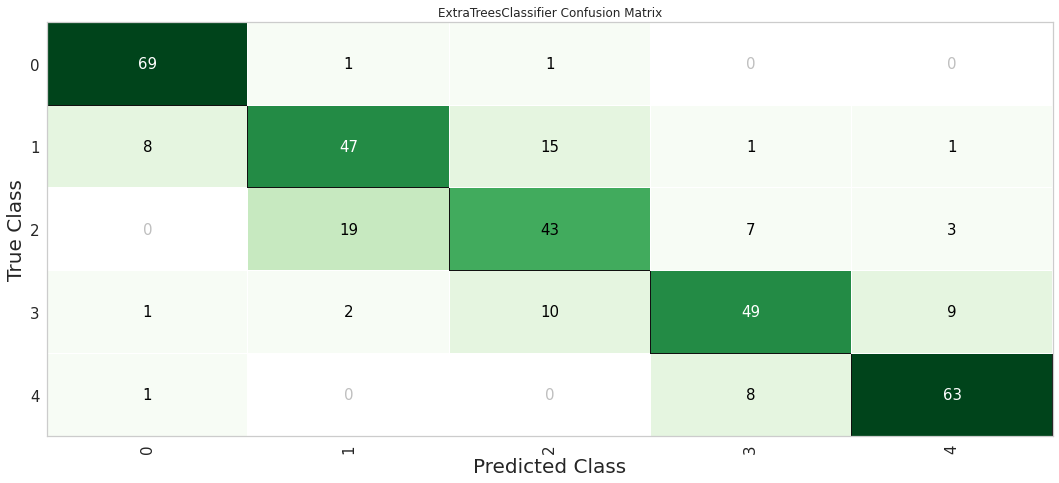

In [208]:
plt.figure(figsize=(15, 7))
plot_model(estimator = tune_et, plot='confusion_matrix')
plt.rc('font', size=50)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=100) # figure title 폰트 크기
plt.show()
#plot_model(estimator = tune_gbr, plot='residuals')
#plot_model(estimator = tune_omp, plot='feature')
#plot_model(estimator = mlp, plot='error')
# plot_model(estimator = tune_mlp, plot='learning')
# plot_model(estimator = tune_mlp, plot='manifold')
# plot_model(estimator = tune_mlp, plot='vc')
# plot_model(estimator = tune_mlp, plot='parameter')

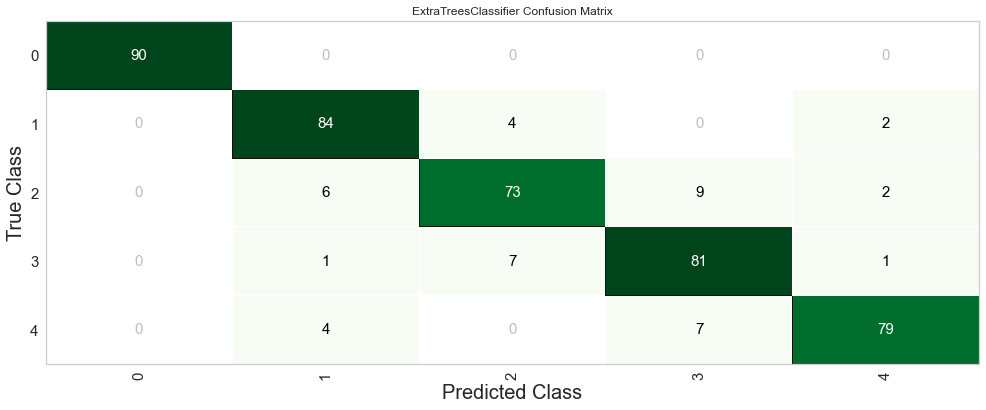

In [15]:
plt.figure(figsize=(15, 7))
plot_model(estimator = blended, plot='confusion_matrix')
plt.rc('font', size=50)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=100) # figure title 폰트 크기
plt.show()
#plot_model(estimator = tune_gbr, plot='residuals')
#plot_model(estimator = tune_omp, plot='feature')
#plot_model(estimator = mlp, plot='error')
# plot_model(estimator = tune_mlp, plot='learning')
# plot_model(estimator = tune_mlp, plot='manifold')
# plot_model(estimator = tune_mlp, plot='vc')
# plot_model(estimator = tune_mlp, plot='parameter')

In [209]:
evaluate_model(tune_et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [210]:
print(xtree_model.feature_importances_)
feature_list = pd.concat([pd.Series(X.columns), pd.Series(xtree_model.feature_importances_)], axis=1)
feature_list.columns = ['features_name', 'importance']
feature_list.sort_values("importance", ascending =False)[:8]

[0.00000000e+00 6.95474789e-04 1.11900330e-03 7.91101996e-04
 8.42861453e-04 1.12785668e-03 1.16256491e-03 1.07668419e-03
 1.21754091e-03 1.20281540e-03 1.33727628e-03 1.71582218e-03
 1.34509261e-03 1.63624987e-03 1.40511903e-03 1.62690162e-03
 1.65998036e-03 1.45644773e-03 1.54316663e-03 1.72934641e-03
 1.79117635e-03 1.84018929e-03 1.25931400e-03 1.93340856e-03
 1.90211618e-03 1.97858444e-03 1.60590559e-03 1.83365420e-03
 1.74569089e-03 1.60430382e-03 1.56346518e-03 1.58756115e-03
 2.09244567e-03 1.41219805e-03 1.71747012e-03 2.49662047e-03
 1.81916425e-03 2.16791314e-03 2.21550289e-03 2.19685030e-03
 2.52036963e-03 2.21161391e-03 2.55433094e-03 2.50575599e-03
 1.82631587e-03 2.18709718e-03 2.46519990e-03 2.67433083e-03
 2.63102465e-03 3.87655372e-03 2.68913911e-03 3.17754023e-03
 2.96572045e-03 4.24722091e-03 3.86568528e-03 3.96278449e-03
 2.98152204e-03 3.87780325e-03 3.37038845e-03 2.89243711e-03
 5.31148119e-03 4.66404544e-03 3.80764137e-03 4.02933965e-03
 3.86837932e-03 6.287121

,features_name,importance
268,blue_12,0.010007
259,blue_3,0.008685
266,blue_10,0.008584
258,blue_2,0.008545
269,blue_13,0.007444
260,blue_4,0.007422
91,gray_91,0.007290
267,blue_11,0.007203


In [211]:
joblib.dump(xtree_model, f'./models/xtree_model_gray+blue+edge_smallRolling_{datetime.today().strftime("%Y%m%d")}.joblib')

['./models/tune_et_gray+blue+edge_smallRolling_20220601.joblib']

In [213]:
model_et = joblib.load('models\\xtree_model_gray+blue+edge_smallRolling_20220601.joblib')
preds = model_et.predict(x_test)
proba = model_et.predict_proba(x_test)
print(proba)

get_clf_eval(y_test, preds)

[[0.69398373 0.18456563 0.03524374 0.04597701 0.04022989]
 [0.44608393 0.39807192 0.10370951 0.04638752 0.00574713]
 [0.90579964 0.04732623 0.01750261 0.01213014 0.01724138]
 ...
 [0.         0.09359606 0.32922824 0.46223317 0.11494253]
 [0.         0.         0.08429119 0.78478251 0.1309263 ]
 [0.         0.03672976 0.14644083 0.76185464 0.05497478]]
오차행렬
[[83  5  0  0  1]
 [ 4 62 12  6  5]
 [ 0 14 60 13  2]
 [ 2  1 14 64  8]
 [ 4  0  3 13 69]]
정확도 : 0.7596
정밀도 : 0.7596
재현율 : 0.7596


In [214]:
roc_auc_score(y_test, proba, multi_class='ovr')

0.9194514581492236

In [215]:
y_test_lb = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

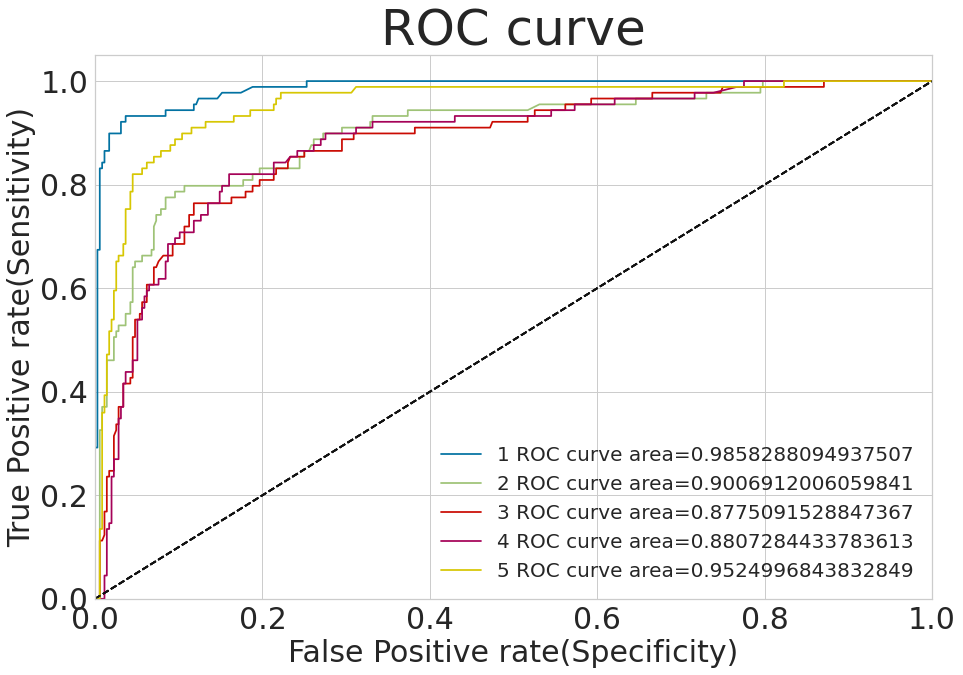

In [217]:
fpr, tpr, roc_auc = {}, {}, {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_lb[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(15, 10))
for idx, i in enumerate(range(5)):
    plt.subplot()
    plt.plot(fpr[i], tpr[i], label=f'{i+1} ROC curve area={roc_auc[i]}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive rate(Specificity)') # 0인 케이스에 대해 0이라고 예측한 것
    plt.ylabel('True Positive rate(Sensitivity)') # 1인 케이스에 대해 1이라고 예측한 것
    plt.title('ROC curve', fontsize=50)
    plt.rc('font', size=100)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize=20)  # 범례 폰트 크기
    plt.rc('figure', titlesize=50) # figure title 폰트 크기
    plt.legend()
    
plt.show()

Text(0.5, 1.0, 'Confusion Matrix')

<Figure size 720x720 with 0 Axes>

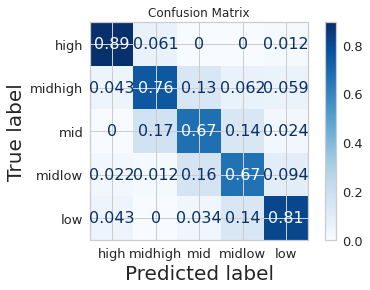

In [225]:
import matplotlib as mpl
# confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label=['high', 'midhigh', 'mid', 'midlow', 'low'] # 라벨 설정

mpl.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10, 10))


plot = plot_confusion_matrix(model_et, # 분류 모델
                             x_test, y_test, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Blues, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize='pred') # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plt.title('title', fontsize=30) # figure title 폰트 크기
plt.rc('font', size=16)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=13)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=13)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


# plt.rc('font', size=10)        # 기본 폰트 크기




plot.ax_.set_title('Confusion Matrix')

Fitting 10 folds for each of 1 candidates, totalling 10 fits


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


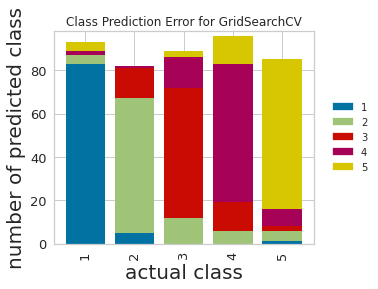

<AxesSubplot:title={'center':'Class Prediction Error for GridSearchCV'}, xlabel='actual class', ylabel='number of predicted class'>

In [221]:
from yellowbrick.classifier import ClassPredictionError
from sklearn.model_selection import GridSearchCV

label = {
        1 : 'high',
        2 : 'midhigh',
        3 : 'mid',
        4 : 'midlow',
        5 : 'low'
        }
plt.title('title', fontsize=10) # figure title 폰트 크기
plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=20, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.000005, n_estimators=87, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)


# parameters = {'max_depth':[7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22], 'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'ccp_alpha' : [v for v in np.arange(0, 10, 1)]}
# parameters = {
#             'min_samples_split':[9], 'ccp_alpha' : [0.0], 'max_depth':[18],
#             'min_impurity_decrease': [0.0000534],
#             }
parameters = {
            'ccp_alpha' : [0.00018], 
            'max_depth': [22],
            'min_samples_split':[3], 
            'min_impurity_decrease': [0.0000534],
            'min_samples_leaf' : [1],
            'min_weight_fraction_leaf' : [0.000005],
            'n_estimators' : [87],
            'random_state' :[3702]
            
            }

# param_grid의 하이퍼 파라미터들을 3개의 train, test set fold 로 나누어서 테스트 수행 설정.  
### refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재 학습 시킴.  
grid_xtree = GridSearchCV(xtree_model, param_grid=parameters, cv=10, refit=True, n_jobs=-1, verbose=10)

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    grid_xtree)

# Fit the training data to the visualizer
visualizer.fit(X,Y)

# Evaluate the model on the test data
visualizer.score(x_test, y_test)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_xtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', \
           'split0_test_score', 
           'split1_test_score', 
           'split2_test_score', 
           'split3_test_score', 
           'split4_test_score',
           'split5_test_score',
           'split6_test_score',
           'split7_test_score',
           'split8_test_score',
           'split9_test_score'
            ]]


# Draw visualization
visualizer.show()



In [222]:
print('GridSearchCV 최적 파라미터:', grid_xtree.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_xtree.best_score_))

# GridSearchCV의 refit으로 이미 학습이 된 estimator 반환
estimator = grid_xtree.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 하이퍼 파라미터로 학습이 됨
pred = estimator.predict(x_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))
scores_df.to_csv('하이퍼파라미터 튜닝.csv')

GridSearchCV 최적 파라미터: {'ccp_alpha': 0.00018, 'max_depth': 22, 'min_impurity_decrease': 5.34e-05, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 5e-06, 'n_estimators': 87, 'random_state': 3702}
GridSearchCV 최고 정확도: 0.6469
테스트 데이터 세트 정확도: 0.7596


In [173]:
# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.00018, class_weight=None,
                     criterion='gini', max_depth=22, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.000005, n_estimators=87, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
                     
xtree_model.fit(X,Y)
preds = xtree_model.predict(x_test)
proba = xtree_model.predict_proba(x_test)
print(proba)

get_clf_eval(y_test, preds)

[[0.69398373 0.18456563 0.03524374 0.04597701 0.04022989]
 [0.44608393 0.39807192 0.10370951 0.04638752 0.00574713]
 [0.90579964 0.04732623 0.01750261 0.01213014 0.01724138]
 ...
 [0.         0.09359606 0.32922824 0.46223317 0.11494253]
 [0.         0.         0.08429119 0.78478251 0.1309263 ]
 [0.         0.03672976 0.1459619  0.76233357 0.05497478]]
오차행렬
[[83  5  0  0  1]
 [ 4 62 12  6  5]
 [ 0 14 60 13  2]
 [ 2  1 14 64  8]
 [ 4  0  3 13 69]]
정확도 : 0.7596
정밀도 : 0.7596
재현율 : 0.7596


In [171]:
# ExtraTreesClassifier
xtree_model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0000534, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.000005, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3702, verbose=0,
                     warm_start=False)
xtree_model.fit(X,Y)
preds = xtree_model.predict(x_test)
proba = xtree_model.predict_proba(x_test)
print(proba)

get_clf_eval(y_test, preds)

[[7.15584026e-01 1.53753918e-01 2.06620553e-02 3.00000000e-02
  8.00000000e-02]
 [5.76930338e-01 3.00911073e-01 8.09721003e-02 2.06601732e-02
  2.05263158e-02]
 [9.36338597e-01 4.23339766e-02 4.71175166e-04 8.56251592e-04
  2.00000000e-02]
 ...
 [1.00000000e-02 1.00000000e-01 3.30000000e-01 3.99375000e-01
  1.60625000e-01]
 [0.00000000e+00 0.00000000e+00 4.02941176e-02 7.99411765e-01
  1.60294118e-01]
 [0.00000000e+00 2.00000000e-02 1.51111111e-01 7.48888889e-01
  8.00000000e-02]]
오차행렬
[[83  5  0  0  1]
 [ 2 64 15  5  3]
 [ 0 16 56 16  1]
 [ 2  1 14 62 10]
 [ 3  0  3 16 67]]
정확도 : 0.7461
정밀도 : 0.7461
재현율 : 0.7461


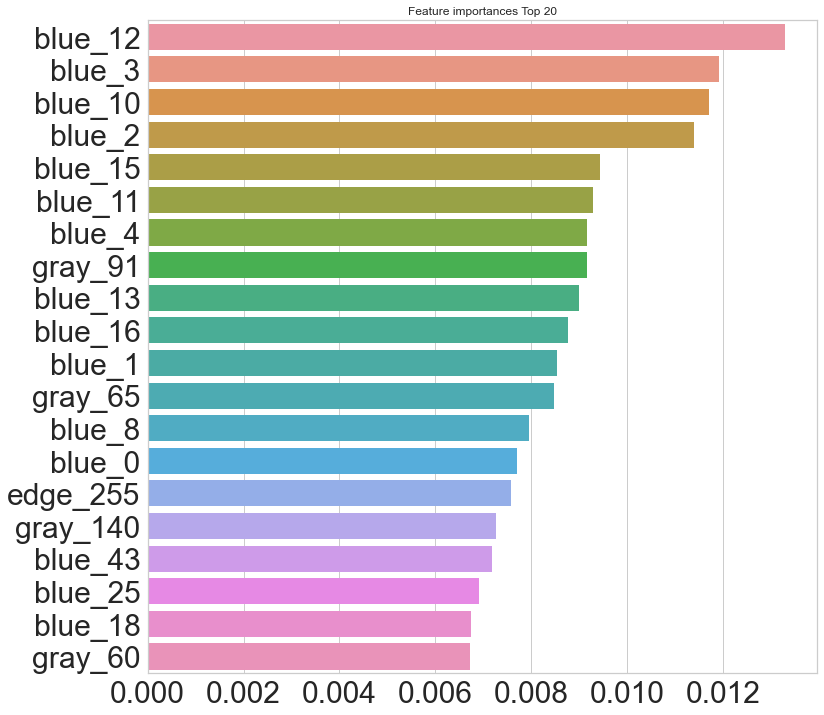

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

importances_values = xtree_model.feature_importances_
importances = pd.Series(importances_values, index=x_train.columns)
top20 = importances.sort_values(ascending=False)[:20]
plt.rc('figure', titlesize=50) # figure title 폰트 크기
plt.figure(figsize=(12, 12))
plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
plt.title('Feature importances Top 20')
sns.barplot(x = top20, y = top20.index)
plt.show()